# Outline

## Defining a measure that prioritizes regions of the manifold for resampling
One can think of multiple ways to define measures that can be used to prioritze regions for resampling. In current studies, one would often define a 'cell-type' of interest and enrich this cell type based on unique surface markers with FACS prior to single-cell RNA-seq. Here, we want to provide an alternative to selecting cell types based on a priori knowledges by using a measure that selects regions that may be of interest. Our ideas for such measures are: 1. density based measure which prioritise low density areas and 2. manifold complexity based measures that quantify whether new local structure of the manifold can be resolved if more samples are added. We chose the difference in kernel density between an unbiased sample and the union  

One of the issues that has been discussed in our group are potential disadvantages of kNN density based scores (or bias functions). From asymptotic considerations, kNN density $\rho(x, k, N)$ of a cell $x$ is dependent on the dimension of the manifold that is being locally occupied by the dataset in the neighborhood of this cell (more precisely, the estimate for $\rho(x, k, N)$ is of the form $c_1(x)^{1/m} \cdot c_2(k, N, m)$). Therefore, simple thresholding procedure on the kNN density seems to select the cells in a local dimension-dependent manner which is not necessarily desirable.

# Set up Environment

Import a bunch of packages that we'll use for the task and import the libraries that will be necessary

In [247]:
import SetEnv
from SetEnv import *
import utils
from given_functions import ImputedSingleCellData
from given_functions import SamplingDistanceEstimator
from given_functions import sample_masked
from utils import *
import scipy
from picturedrocks import Rocks
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read bone marrow data

### The full dataset - initialize a scanpy object and normalize

In [176]:
path = os.path.expanduser('~/data/tasks/sampling/')
raw = sc.read_h5ad(path + 'ica_bone_marrow.h5ad')
sc.pp.normalize_per_cell(raw, counts_per_cell_after=1e4)

    normalizing by total count per cell
    filtered out 0 cells that have less than 1 counts
        finished (0:00:04.94): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [177]:
# load data for fast objective evaluation
init_set = pd.Index(pd.read_csv(path + 'ica_bone_marrow_inital_cells_15k.csv', header=None).iloc[:, 0])
ref_set_sigmas = pd.read_csv(path + 'ica_bone_marrow_ref_set_sigmas.csv', index_col=0, header=None).iloc[:, 0]
sde = SamplingDistanceEstimator(raw, ref_set_sigmas)
dist, init_ref_sphere_counts = sde.determine_distance(init_set)

In [179]:
adata = raw.copy()
sc.pp.log1p(adata)

### Read the scanpy instance of the 10k bonemarrow cells

Perform basic preprocessing + PCA and compute KNN-density

In [224]:
adata_orig_subset = sc.read_h5ad('../task_description/ica_bone_marrow_inital_cells_15k.h5ad')
sc.pp.log1p(adata_orig_subset)
auto_prepr(adata_orig_subset, 200) # PCA + KNN graph

    compute PCA with n_comps = 50
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
        finished (0:00:19.21)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:10.25)
    computed connectivities (0:00:14.21)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Compute tSNE embedding of 10k cells

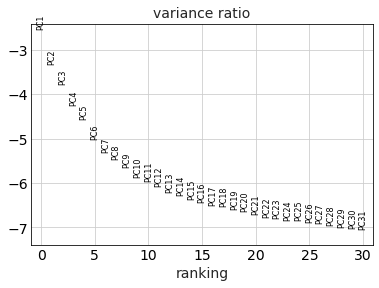

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[t-SNE] Computed neighbors for 10000 samples in 2.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.554151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.221260
[t-SNE] Error after 1000 iterations: 1.516909
    finished (0:04:43.93) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [7]:
sc.pl.pca_variance_ratio(adata_orig_subset, log=True) # 30 PCs
sc.tl.tsne(adata_orig_subset, random_state=2, n_pcs=30)

### Create an aggregated subset with 20k cells including the 10k original cells.

We will examine how the knn density in the neighborhood of the original datapoints changes with the addition of 10k cells

In [4]:
orig_index = adata_orig_subset.obs_names.values # Indices of cells in the subset
all_index = adata.obs_names.values # Indices of all cells
num_cells = 10000
random_index = np.random.choice(list(set(all_index) - set(orig_index)), num_cells, replace=False)
aggr_index = np.concatenate([random_index, orig_index])
adata_aggr_subset = subset(adata, aggr_index)

array([ True,  True,  True, ...,  True,  True,  True])

Preprocess the aggregated subset and compute knn density

In [5]:
auto_prepr(adata_aggr_subset, 200)

    compute PCA with n_comps = 50
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
        finished (0:00:37.85)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:20.68)
    computed connectivities (0:00:28.56)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Compute tSNE for the aggregated subset

In [10]:
sc.tl.tsne(adata_aggr_subset, random_state=2, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.024s...
[t-SNE] Computed neighbors for 20000 samples in 6.639s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Com

# Compute knn density of the original and aggregated subsets

Computing the corresponding normalized logdensities

In [9]:
orig_density = dens(adata_orig_subset)
aggr_density = dens(adata_aggr_subset)
in_common = adata_orig_subset.obs_names.intersection(adata_aggr_subset.obs_names)
normlog_orig_density = np.log(orig_density.loc[in_common] / np.sum(orig_density.loc[in_common]))
normlog_aggr_density = np.log(aggr_density.loc[in_common] / np.sum(aggr_density.loc[in_common]))                           

Plot the logdensities against each other and calculate the density corrcoef

[[1.         0.94819435]
 [0.94819435 1.        ]]


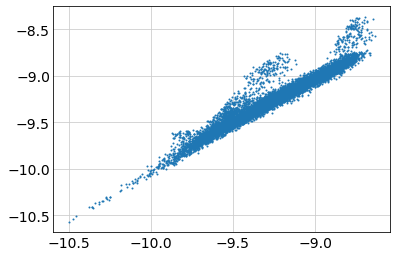

In [13]:
plt.scatter(normlog_orig_density, normlog_aggr_density, s = 1)
print(np.corrcoef(np.ravel(orig_density), np.ravel(aggr_density.loc[in_common])))

The score: log of the ratio of the densities

In [26]:
score = normlog_orig_density - normlog_aggr_density

Plot the original density and the new score on the tsne of the original dataset

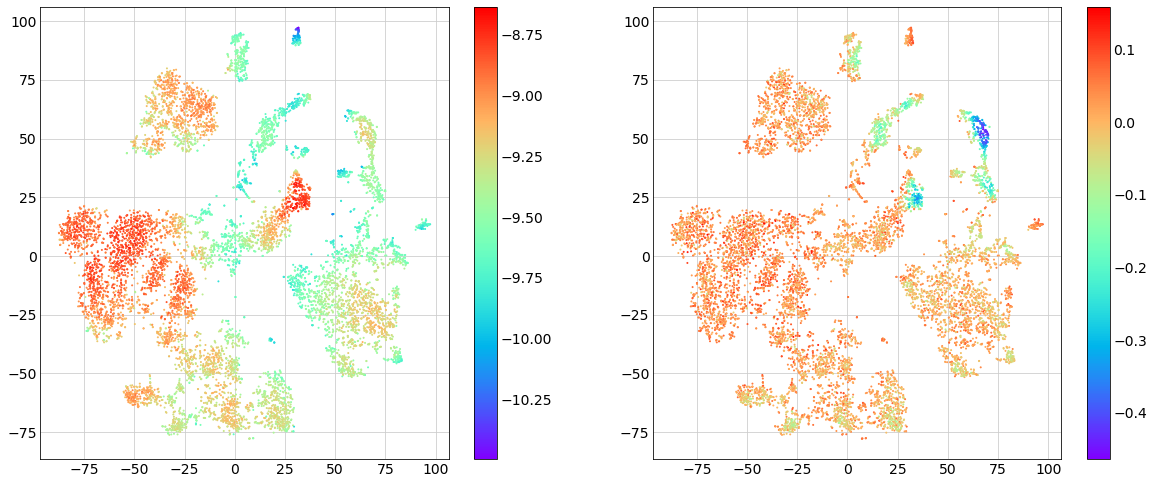

In [29]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(adata_orig_subset.obsm.X_tsne[:,0], adata_orig_subset.obsm.X_tsne[:,1], c = normlog_orig_density[0].values, cmap = 'rainbow', s =1)
plt.colorbar()
plt.subplot(122)
plt.scatter(adata_orig_subset.obsm.X_tsne[:,0], adata_orig_subset.obsm.X_tsne[:,1], c = score[0].values, cmap = 'rainbow', s =1)
plt.colorbar()

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


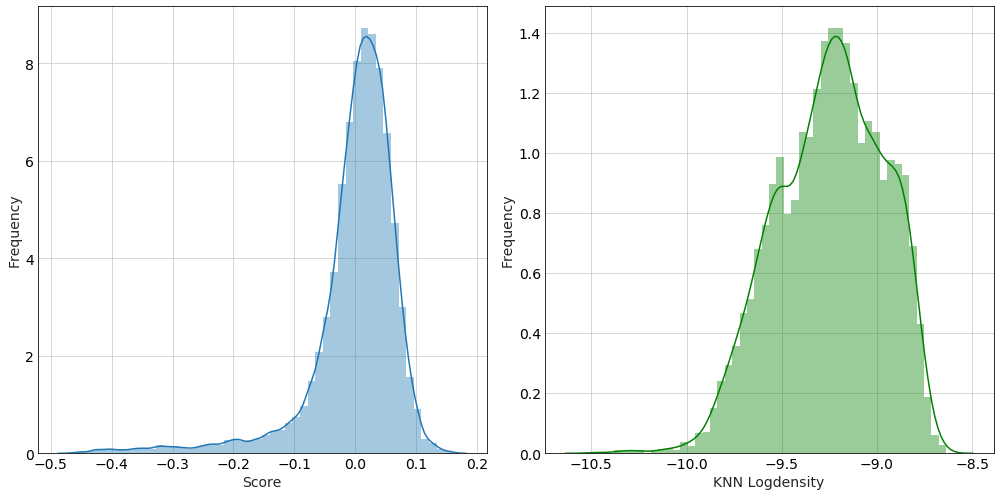

In [48]:
# the histogram of the data
import seaborn as sns
fig = plt.figure(figsize=[14, 7])
gs = plt.GridSpec(1,2)
ax = plt.subplot(gs[0,0])
sns.distplot(score[0].values, hist = True)
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.title(r'$\mathrm{Histogram\ of\ } \Delta density$')

plt.subplot(122)
ax = plt.subplot(gs[0, 1])
sns.distplot(normlog_orig_density[0].values, hist = True, color='green')
plt.xlabel('KNN Logdensity')
plt.ylabel('Frequency')
#plt.title(r'$\mathrm{Histogram\ of\ } KNN logdensity$')
plt.tight_layout()

# Run a new experiment

This procedure prioritises cells for the gate based on density information and density change versus the last iteration.
Uses union of the most interesting cells with respect to each score to fall in the gate.
It then defines connected neighbourboods based on these selected cells and selects the largest neighourhood for gating.
We then fit a linear classifier to define a gating rule based on 6 genes to distinguish the selected set of cells from the rest.
We apply the gating rule to sample 5000 new cells and repeat this process 5 times.

things to improve
- dont resample cells across experiments

In [209]:
adata_old = adata_orig
adata_old = sc.pp.subsample(data=adata_orig_subset, fraction=0.5, copy=False)
_, ref_sphere_counts = sde.determine_distance(adata_old.obs_names)
print(sde.determine_distance_from_occupancy(init_ref_sphere_counts + ref_sphere_counts))

    ... subsampled to 1250 data points


AttributeError: 'NoneType' object has no attribute 'obs_names'

In [ ]:
adata_old = adata_orig_subset.copy()
sc.pp.subsample(data=adata_old, fraction=0.5, copy=False)
auto_prepr(adata_old)

adata_new = adata_orig_subset.copy()

_, ref_sphere_counts = sde.determine_distance(adata_old.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

_, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

score_id = 'aggregate'
for i in range(5):
    print('iteration ' + str(i))
    orig_density = dens(adata_old)
    aggr_density = dens(adata_new)
    in_common = adata_old.obs_names
    normlog_orig_density = np.log(orig_density.loc[in_common] / np.sum(orig_density.loc[in_common]))
    normlog_aggr_density = np.log(aggr_density.loc[in_common] / np.sum(aggr_density.loc[in_common]))
    
    if(score_id=='density'):
        score = normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = [score.index.get_loc(cell) for cell in (score.loc[score[0].values >= lower_thres_score]).index]
    elif(score_id=='density_change'):
        score = normlog_orig_density - normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = [score.index.get_loc(cell) for cell in (score.loc[score[0].values >= lower_thres_score]).index]
    elif(score_id=='aggregate'):
        score1 = normlog_aggr_density
        score2 = normlog_orig_density - normlog_aggr_density
        lower_thres_score1 = np.mean(score1[0].values)-np.std(score1[0].values)
        lower_thres_score2 = np.mean(score2[0].values)-np.std(score2[0].values)
        target_cells1 = np.where(score1[0].values >= lower_thres_score1)[0]
        target_cells2 = np.where(score2[0].values >= lower_thres_score2)[0]
        target_cells = np.union1d(target_cells1, target_cells2).tolist()

    clusters = connected_components(adata_new, target_cells)
    
    target_cluster = clusters[0]
    
    cluster_assign = genClustsCC(adata_new, np.array(target_cells)[clusters[0]])
    feature_select = Rocks(adata_new.X.A, cluster_assign.astype(int), verbose=1)
    _ = genConsts(feature_select, alpha=0.05, lambFac=0.01)
    markers = getMarks(feature_select, 1)
    markers_ids = adata_new.var_names[markers]
    classifier_weights = getWeights(feature_select, 1, markers)
    offset = utils.getOffset(adata_new, markers, classifier_weights, feature_select.cs_scales[1])
    
    imputed = ImputedSingleCellData.read_h5im(path + '/ica_bone_marrow.h5im')
    
    adata_sample = biased_experiment(
        path + '/ica_bone_marrow.h5im', adata, gate_fun='linearclass', 
        gate_genes=markers_ids, gate_list = [classifier_weights, offset], n_cells=5000)
    
    adata_old = adata_new.copy()
    adata_new = adata_new.concatenate(adata_sample, index_unique=None, batch_key='isold')
    auto_prepr(adata_new)
    
    _, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
    print(sde.determine_distance_from_occupancy(ref_sphere_counts))

    ... subsampled to 5000 data points
    compute PCA with n_comps = 50
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
        finished (0:00:09.83)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    initialized `.distances` `.connectivities` 
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.54)
    computed connectivities (0:00:12.87)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [ ]:
adata_old = adata_orig_subset.copy()
sc.pp.subsample(data=adata_old, fraction=0.5, copy=False)
auto_prepr(adata_old)

adata_new = adata_orig_subset.copy()

_, ref_sphere_counts = sde.determine_distance(adata_old.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

_, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

score_id = 'density'
for i in range(5):
    print('iteration ' + str(i))
    orig_density = dens(adata_old)
    aggr_density = dens(adata_new)
    in_common = adata_old.obs_names
    normlog_orig_density = np.log(orig_density.loc[in_common] / np.sum(orig_density.loc[in_common]))
    normlog_aggr_density = np.log(aggr_density.loc[in_common] / np.sum(aggr_density.loc[in_common]))
    
    if(score_id=='density'):
        score = normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='density_change'):
        score = normlog_orig_density - normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='aggregate'):
        score1 = normlog_aggr_density
        score2 = normlog_orig_density - normlog_aggr_density
        lower_thres_score1 = np.mean(score1[0].values)-np.std(score1[0].values)
        lower_thres_score2 = np.mean(score2[0].values)-np.std(score2[0].values)
        target_cells1 = np.where(score1[0].values >= lower_thres_score1)[0]
        target_cells2 = np.where(score2[0].values >= lower_thres_score2)[0]
        target_cells = np.union1d(target_cells1, target_cells2).tolist()

    clusters = connected_components(adata_new, target_cells)
    
    target_cluster = clusters[0]
    
    cluster_assign = genClustsCC(adata_new, np.array(target_cells)[clusters[0]])
    feature_select = Rocks(adata_new.X.A, cluster_assign.astype(int), verbose=1)
    _ = genConsts(feature_select, alpha=0.05, lambFac=0.01)
    markers = getMarks(feature_select, 1)
    markers_ids = adata_new.var_names[markers]
    classifier_weights = getWeights(feature_select, 1, markers)
    offset = utils.getOffset(adata_new, markers, classifier_weights, feature_select.cs_scales[1])
    
    imputed = ImputedSingleCellData.read_h5im(path + '/ica_bone_marrow.h5im')
    
    adata_sample = biased_experiment(
        path + '/ica_bone_marrow.h5im', adata, gate_fun='linearclass', 
        gate_genes=markers_ids, gate_list = [classifier_weights, offset], n_cells=5000)
    
    adata_old = adata_new.copy()
    adata_new = adata_new.concatenate(adata_sample, index_unique=None, batch_key='isold')
    auto_prepr(adata_new)
    
    _, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
    print(sde.determine_distance_from_occupancy(ref_sphere_counts))

In [ ]:
adata_old = adata_orig_subset.copy()
sc.pp.subsample(data=adata_old, fraction=0.5, copy=False)
auto_prepr(adata_old)

adata_new = adata_orig_subset.copy()

_, ref_sphere_counts = sde.determine_distance(adata_old.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

_, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

score_id = 'aggregate'
for i in range(5):
    print('iteration ' + str(i))
    orig_density = dens(adata_old)
    aggr_density = dens(adata_new)
    in_common = adata_old.obs_names
    normlog_orig_density = np.log(orig_density.loc[in_common] / np.sum(orig_density.loc[in_common]))
    normlog_aggr_density = np.log(aggr_density.loc[in_common] / np.sum(aggr_density.loc[in_common]))
    
    if(score_id=='density'):
        score = normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='density_change'):
        score = normlog_orig_density - normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='aggregate'):
        score1 = normlog_aggr_density
        score2 = normlog_orig_density - normlog_aggr_density
        lower_thres_score1 = np.mean(score1[0].values)-np.std(score1[0].values)
        lower_thres_score2 = np.mean(score2[0].values)-np.std(score2[0].values)
        target_cells1 = np.where(score1[0].values >= lower_thres_score1)[0]
        target_cells2 = np.where(score2[0].values >= lower_thres_score2)[0]
        target_cells = np.union1d(target_cells1, target_cells2).tolist()

    clusters = connected_components(adata_new, target_cells)
    
    target_cluster = clusters[i]
    
    cluster_assign = genClustsCC(adata_new, np.array(target_cells)[clusters[0]])
    feature_select = Rocks(adata_new.X.A, cluster_assign.astype(int), verbose=1)
    _ = genConsts(feature_select, alpha=0.05, lambFac=0.01)
    markers = getMarks(feature_select, 1)
    markers_ids = adata_new.var_names[markers]
    classifier_weights = getWeights(feature_select, 1, markers)
    offset = utils.getOffset(adata_new, markers, classifier_weights, feature_select.cs_scales[1])
    
    imputed = ImputedSingleCellData.read_h5im(path + '/ica_bone_marrow.h5im')
    
    adata_sample = biased_experiment(
        path + '/ica_bone_marrow.h5im', adata, gate_fun='linearclass', 
        gate_genes=markers_ids, gate_list = [classifier_weights, offset], n_cells=5000)
    
    adata_old = adata_new.copy()
    adata_new = adata_new.concatenate(adata_sample, index_unique=None, batch_key='isold')
    auto_prepr(adata_new)
    
    _, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
    print(sde.determine_distance_from_occupancy(ref_sphere_counts))

In [ ]:
adata_old = adata_orig_subset.copy()
sc.pp.subsample(data=adata_old, fraction=0.5, copy=False)
auto_prepr(adata_old)

adata_new = adata_orig_subset.copy()

_, ref_sphere_counts = sde.determine_distance(adata_old.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

_, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

score_id = 'aggregate'
for i in range(5):
    print('iteration ' + str(i))
    orig_density = dens(adata_old)
    aggr_density = dens(adata_new)
    in_common = adata_old.obs_names
    normlog_orig_density = np.log(orig_density.loc[in_common] / np.sum(orig_density.loc[in_common]))
    normlog_aggr_density = np.log(aggr_density.loc[in_common] / np.sum(aggr_density.loc[in_common]))
    
    if(score_id=='density'):
        score = normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='density_change'):
        score = normlog_orig_density - normlog_aggr_density
        lower_thres_score = np.mean(score[0].values)-np.std(score[0].values)
        target_cells = np.where(score[0].values >= lower_thres_score)[0]
    elif(score_id=='aggregate'):
        score1 = normlog_aggr_density
        score2 = normlog_orig_density - normlog_aggr_density
        lower_thres_score1 = np.mean(score1[0].values)-np.std(score1[0].values)
        lower_thres_score2 = np.mean(score2[0].values)-np.std(score2[0].values)
        target_cells1 = np.where(score1[0].values >= lower_thres_score1)[0]
        target_cells2 = np.where(score2[0].values >= lower_thres_score2)[0]
        target_cells = np.union1d(target_cells1, target_cells2).tolist()

    clusters = connected_components(adata_new, target_cells)
    
    target_cluster = clusters[0]
    
    cluster_assign = genClustsCC(adata_new, np.array(target_cells)[clusters[0]])
    feature_select = Rocks(adata_new.X.A, cluster_assign.astype(int), verbose=1)
    _ = genConsts(feature_select, alpha=0.05, lambFac=0.01)
    markers = getMarks(feature_select, 1)
    markers_ids = adata_new.var_names[markers]
    classifier_weights = getWeights(feature_select, 1, markers)
    offset = utils.getOffset(adata_new, markers, classifier_weights, feature_select.cs_scales[1])
    
    imputed = ImputedSingleCellData.read_h5im(path + '/ica_bone_marrow.h5im')
    
    adata_sample = biased_experiment(
        path + '/ica_bone_marrow.h5im', adata, gate_fun='linearclass', 
        gate_genes=markers_ids, gate_list = [classifier_weights, offset], n_cells=5000)
    
    adata_old = adata_new.copy()
    adata_new = adata_new.concatenate(adata_sample, index_unique=None, batch_key='isold')
    auto_prepr(adata_new)
    
    _, ref_sphere_counts = sde.determine_distance(adata_new.obs_names)
    print(sde.determine_distance_from_occupancy(ref_sphere_counts))

In [281]:
adata_unbiased = subset(adata, np.random.choice(list(set(all_index) - set(orig_index)), 25000, replace=False))
adata_unbiased_merged = adata_orig_subset.concatenate(adata_unbiased, index_unique=None, batch_key='isold')

_, ref_sphere_counts = sde.determine_distance(adata_unbiased_merged.obs_names)
print(sde.determine_distance_from_occupancy(ref_sphere_counts))

0.30846666666666667


visualise results

In [169]:
sc.pp.normalize_per_cell(adata_merged)
sc.pp.log1p(adata_merged)
sc.pp.pca(adata_merged)
sc.tl.tsne(adata_merged)

    normalizing by total count per cell
    filtered out 0 cells that have less than 1 counts
        finished (0:00:00.25): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)
    compute PCA with n_comps = 50
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
        finished (0:00:37.52)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.034s...
[t-SNE] Computed neighbors for 20000 samples in 9.211s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] C

plot tsne with scores superimposed + plot with new cells highlighted

In [ ]:
sc.pl.tsne(adata_orig_subset)
sc.pl.tsne(adata_merged)